## __생활인구 데이터 활용 가능성 평가__

----------------------------------------------------------------------
### __Intro__
* 본 ipynb는 전처리 과정을 통해 집계된 생활 인구 데이터를 실시간 인구 데이터 예측에 활용할 수 있는지 평가하는 과정을 설명합니다. 
* 지하철 역 단위로 추정된 생활 인구 데이터는 "./#1 데이터전처리/#1 생활인구 데이터 수집/#2 생활인구 데이터 전처리/지하철역 생활인구 추정 및 구축 과정.ipynb"를 실행시킨 결과를 사용해주시길 바랍니다.
  
### __사용 데이터__
* 실시간 도시 데이터 집계 범위: https://data.seoul.go.kr/dataList/OA-21778/A/1/datasetView.do
* 생활 인구 데이터 집계 범위(집계구): https://data.seoul.go.kr/dataList/OA-14979/S/1/datasetView.do#

### __목적__
* 생활 인구 데이터(LP)와 실시간 인구 데이터(RP) 비교를 통한 정확도 및 상관성 분석

### __필요성__
* CamelNeon은 서울시에서 제공하는 실시간 도시 데이터(이하, rp)로부터, 지하철 역 내 유동인구 데이터를 수집함
  * 그러나, rp는 과거 기록을 제공하지 않아 타 데이터와 비교가 불가능함
  * 또한, 유동인구 예측 모델 개발 등 타 개발로 확장이 어려움
* 같은 서울시에서 제공하는 생활 인구 데이터(이하, lp)는 과거 데이터를 제공함
  * 그러나, 집계구 단위로 제공하기에 본 프로젝트(CamelNeon)에 적용하기 어려움
* 따라서, 추정된 LP와 RP를 비교 분석하여, 향 후 RP 예측모델에 LP를 기반을 훈련된 LSTM 모델을 사용할 수 있는지 판단하고자 함.

### 구조
* SQL_parameter.json: RP가 저장된 SQL을 받아오기 위한 정보가 담겨있습니다.
* util_pop.py: 생활인구 처리 관련 util 모듈
* 대상집계구 생활인구.csv: ./#1 데이터전처리/#1 생활인구 데이터 수집/#2 생활인구 데이터 전처리/지하철역 생활인구 추정 및 구축 과정.ipynb"를 실행시킨 결과물

In [1]:
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import json
from sqlalchemy import create_engine
import urllib.parse
from sklearn.metrics import r2_score
from util_pop import *

In [2]:
region_to_area = {1: '삼각지역', 2: '군자역', 3: '회기역', 4:'용산역'} #현재 RP는 좌측에 작성된 4개의 지역만 수집중입니다.
target_areas = ['삼각지역', '군자역', '회기역', '용산역']
detail_option = False # 지역별 분석 결과도 확인하고자 할때 True로 설정하십시오

### __1. RP 데이터 가져오기__

In [3]:
with open('./SQL_parameter.json') as f:
    par = json.load(f)
host = par['host']
port = par['port']
username = par['username']
password = par['password']
database = par['database']

# 비밀번호 URL 인코딩
encoded_password = urllib.parse.quote_plus(password)

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{username}:{encoded_password}@{host}:{port}/{database}")

db_pop = import_db_data(engine, 0, option=False)
db_pop, cols = calculate_columns(db_pop)
db_pop['AREA_NM'] = db_pop['region_id'].map(region_to_area)
db_pop.head(3)

,datetime,region_id,max_population,10gen_male_db,10gen_female_db,20gen_male_db,20gen_female_db,30gen_male_db,30gen_female_db,40gen_male_db,40gen_female_db,50gen_male_db,50gen_female_db,60gen_male_db,60gen_female_db,AREA_NM
0,2025-01-07 14:30:00,1,2500,50.5975,41.9025,217.4325,180.0675,307.6875,254.8125,263.9275,218.5725,232.475,192.525,159.9975,132.5025,삼각지역
1,2025-01-07 14:35:00,1,2000,31.8000,28.2000,172.7800,153.2200,234.2600,207.7400,208.8200,185.1800,182.320,161.680,126.1400,111.8600,삼각지역
2,2025-01-07 14:35:00,2,9000,204.7500,245.2500,810.8100,971.1900,773.9550,927.0450,671.5800,804.4200,655.200,784.800,528.2550,632.7450,군자역


### __2. LP 데이터 가져오기__
* RP 기준으로 수집되고 있는 지역의 데이터만 사용합니다.
* 본 프로젝트에서는 대상지역 전부를 취합한 코드는 제공하지 않으므로, 대상집계구 생활인구.csv는 따로 제공합니다.

In [4]:
fn = '대상집계구 생활인구.csv'
lp_pop = import_real_data(fn, target_areas)
lp_pop.head(3)

,Datetime,총생활인구수,10gen_male_lp,10gen_female_lp,20gen_male_lp,20gen_female_lp,30gen_male_lp,30gen_female_lp,40gen_male_lp,40gen_female_lp,50gen_male_lp,50gen_female_lp,60gen_male_lp,60gen_female_lp,AREA_NM
2112,2025-01-07 00:00:00,9414.676777,208.119579,290.063566,931.725789,1418.936503,975.490098,1073.903272,671.024269,725.070435,571.550993,496.084543,322.291366,432.168094,군자역
2113,2025-01-07 01:00:00,9367.119939,190.797062,283.642090,931.354121,1406.207155,922.522966,1096.429760,674.791808,727.838661,550.556400,515.159456,322.039813,430.537902,군자역
2114,2025-01-07 02:00:00,9223.352030,185.334234,262.682446,890.052628,1386.371814,955.200454,1073.476590,665.988809,737.227481,515.226594,524.520681,332.058350,435.434819,군자역


### __3. 두 종의 데이터 결합__
* RP는 5분 단위, LP는 1시간 단위로 제공하므로, LP 시간단위에 맞춰서 두 데이터 종을 결합함

In [5]:
selected_cols = import_df_columns()
final_df = edit_final_data(db_pop, lp_pop, selected_cols, target_areas)

### 4. 상관성 분석 및 신뢰성($R^2$) 분석
* 각 연령/성별 별 산점도와 R제곱을 통해 신뢰도를 평가하였습니다.
* R제곱 기준 대부분의 연령에서 0.7이상에 높은 신뢰성을 나타냈으나, 일부 시사점이 있습니다.
  * 대상 지역들은 10대 유동인구가 높은 지역이 아님. 이는 10대의 정확도가 낮은것으로 나타납니다.
  * 20대 여성 또한 R제곱이 낮은 편입니다. 20대 여성 비율이 높은 삼각지역과 회귀역을 분석한 결과 아래와 같은 시사점을 찾았습니다.
    * 추정값는 실제 인구수와 선형을 이루며 데이터 내에서 그 순위가 변하지는 않습니다. 따라서, 최종적으로 구축하는 알고리즘이 인구수 순위를 기준으로 동작하기에 추정 데이터를 사용하여도 영향이 없을것으로 판단됩니다.
    * 삼각지와 회귀는 타 지역에 비해 구성되는 집계구가 많습니다. 또한 해당 집계구의 여성 유동인구 수도 높은편입니다. 이것이 과하게 추정하게 만드는 원인이 된것으로 판단됩니다.
    * 현재 실시간 인구 데이터는 5일 치 정도 수집된 상태입니다. 더 많은 데이터를 수집하여 재분석을 진행할 경우, 더 높은 수준의 결과를 얻을 수 있을것으로 예상됩니다.
* 각 세대 별 상관계수를 계산한 결과 0.9이상의 높은 상관성을 나타냈습니다.
* __위 결과들에 근거하여 본 프로젝트에서 구축한 추정 인구수는 다른 분석에서 실시간 인구 데이터를 대체할 수 있을것으로 최종 판단 하였습니다.__

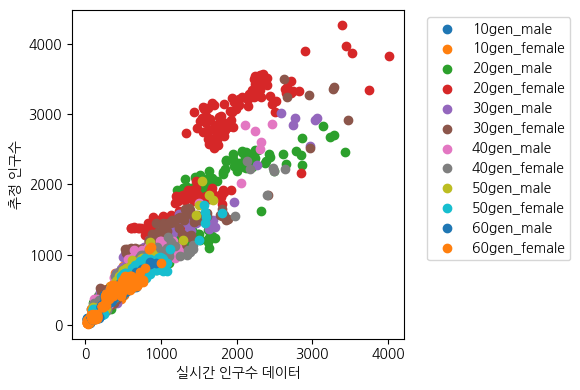

,male,female
10_gen,0.539662,0.323216
20_gen,0.877411,0.396135
30_gen,0.798276,0.835467
40_gen,0.757691,0.879117
50_gen,0.739082,0.887909
60_gen,0.877774,0.842533


In [6]:
df = compare_pop(final_df)
df_list = []
if detail_option == True:
    for target in target_areas:
        target_df = final_df.loc[(final_df['AREA_NM_x']==target)]
        df_ = compare_pop(target_df)
        df_list.append(df_)
display(df)

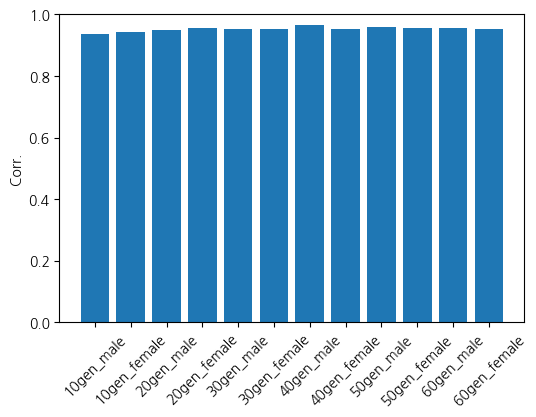

In [7]:
corr_bar(final_df, detail_option, 0)
if detail_option == True:
    for target in target_areas:
        target_df = final_df.loc[(final_df['AREA_NM_x']==target)]
        corr_bar(target_df, detail_option, target)

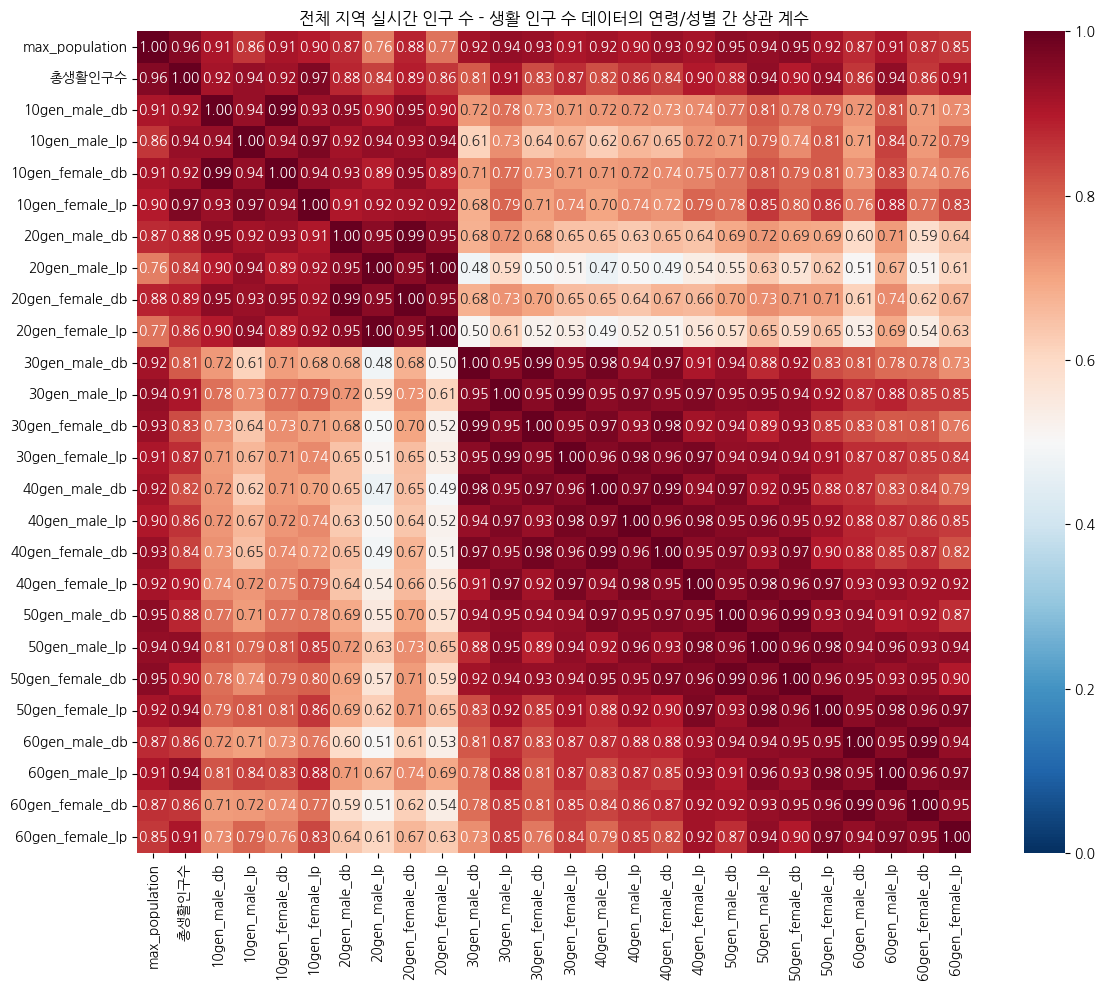

In [8]:
analyze_correlations(final_df, 1)
if detail_option == True:
    for target in target_areas:
        target_df = final_df.loc[(final_df['AREA_NM_x']==target)]
        analyze_correlations(target_df, 1, target)